In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def quadratic_function(x):
    return 3 * x**2 - 4 * x + 5

xs = np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

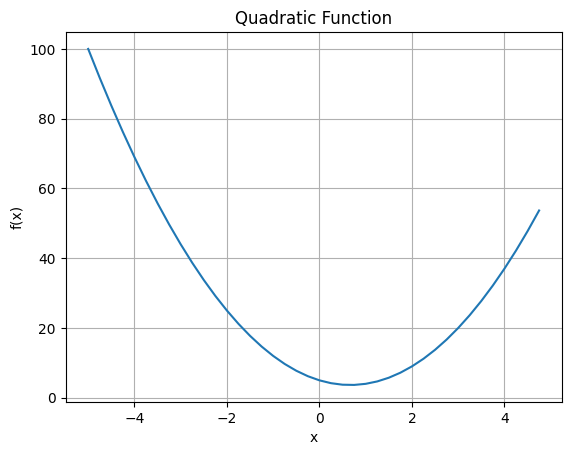

In [3]:
ys = quadratic_function(xs)
plt.plot(xs,ys)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Quadratic Function')
plt.grid()
plt.show()

### Building MicroGrad

In [4]:
# we will know the children of every single value in the graph
# and the operation that created those values

# At initialization grad will be 0.0, as the value does not impact the output
# As keeping the gradient zero does not change the loss function.
# for example, for node 'a' grad will be dL/da


class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0  # This will hold the gradient for backpropagation
        self._prev = set(_children)  # This is used to keep track of the previous values for backpropagation
        self._op = _op
        self._backward = lambda: None  # This will be used to define the backward function for backpropagation
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # [example here is we get a+1]
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward 
        return out
    
    def __radd__(self, other):  # checks if left side is a number and based in that it will call the __add__ method
        # This allows us to use the addition operator on the left side, e.g., 2 + a
        return self + other
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        return out
    
    def __rsub__(self, other):  # checks if left side is a number and based in that it will call the __sub__ method
        # This allows us to use the subtraction operator on the left side, e.g., 2 - a
        return -self + other  # This will call the __add__
    
    def __rmul__(self, other): # checks if left side is a number and based in that it will call the __mul__ method
        # This allows us to use the multiplication operator on the left side, e.g., 2 * a
        return self * other
        # return self.__mul__(other) if isinstance(other, Value) else Value(self.data * other, (self,), '*')
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) 
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other): # a/b
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data**-1, (self, other), '/')
        def _backward():
            self.grad += 1.0 * other.data**-1 * out.grad
            other.grad += -self.data / (other.data**2) * out.grad
        out._backward = _backward
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be an integer or float"
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        self.grad = 1.0

        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
                topo.append(node)

        build_topo(self)

        topo.reverse()
        for node in topo:
            node._backward()

        

a = Value(2.0,label='a')
b = Value(3.0,label='b')
c = Value(7.0,label='c')        # a + b -> a.__add__(b) this is called operator overloading
d = Value(-2,label='d')     

e = a * b        # a * b -> a.__mul__(b)
e.label = 'e'   

print(a,b,c,d)
f = e + c    # a + (b * c) -> (a.__mul__(b)).__add__(c)
f.label = 'f'

L = d * f
L.label = 'L'
print(e)
print(d._prev)
print(e._prev)  # this will show the previous values that were used to compute e 
print(d._op)  # this will show the operation that was used to compute d
print(e._op)  # this will show the operation that was used to compute e


Value(data=2.0) Value(data=3.0) Value(data=7.0) Value(data=-2)
Value(data=6.0)
set()
{Value(data=2.0), Value(data=3.0)}

*


In [5]:
2 * a

Value(data=4.0)

In [6]:
# lets visualize the graph

from graphviz import Digraph

# trace gets all the nodes and edges going from the output node to the input nodes
# it will return a set of nodes and a set of edges
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [7]:
# here it retuns the nodes and the edges 
print('Nodes and Edges. of e:')
print(trace(e))

print('Nodes and Edges. of d:')
print(trace(d))

Nodes and Edges. of e:
({Value(data=2.0), Value(data=3.0), Value(data=6.0)}, {(Value(data=2.0), Value(data=6.0)), (Value(data=3.0), Value(data=6.0))})
Nodes and Edges. of d:
({Value(data=-2)}, set())


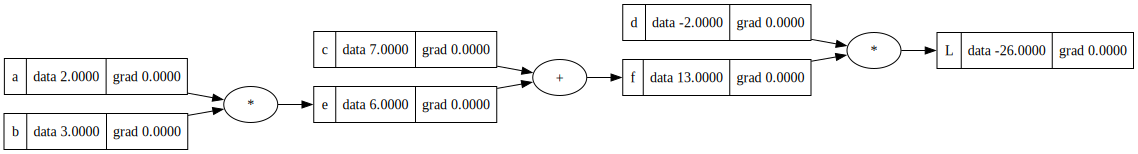

In [8]:
draw_dot(L)

In [9]:
L.grad = 1.0  # This is the gradient of the loss with respect to L, which is 1.0 for the output node
# Now we will backpropagate the gradients through the graph

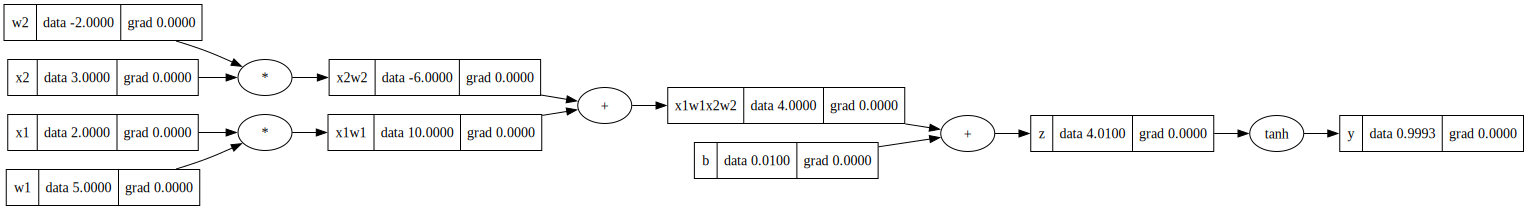

In [10]:
x1 = Value(2.0, label='x1')
x2 = Value(3.0, label='x2')

w1 = Value(5.0, label='w1')
w2 = Value(-2.0, label='w2')

b = Value(0.01, label='b')

x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'
z = x1w1x2w2 + b
z.label = 'z'

y = z.tanh()
y.label = 'y'

# Now we will backpropagate the gradients through the graph
draw_dot(y)

In [11]:
# base case 
y.grad = 1.0 

y._backward() 

z._backward()


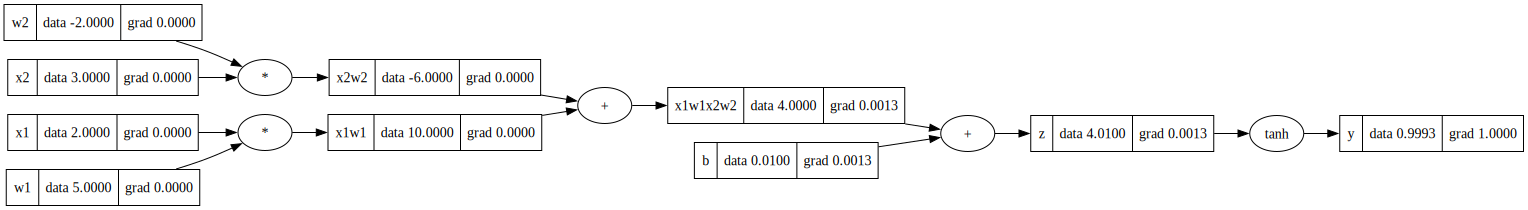

In [12]:
draw_dot(y)

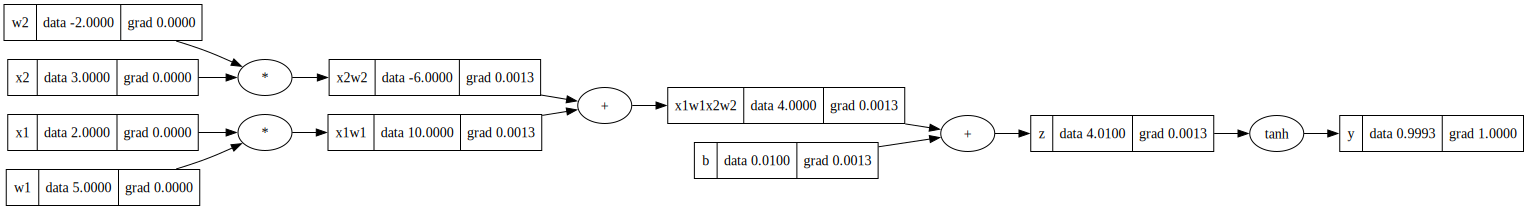

In [13]:
x1w1x2w2._backward()
draw_dot(y)

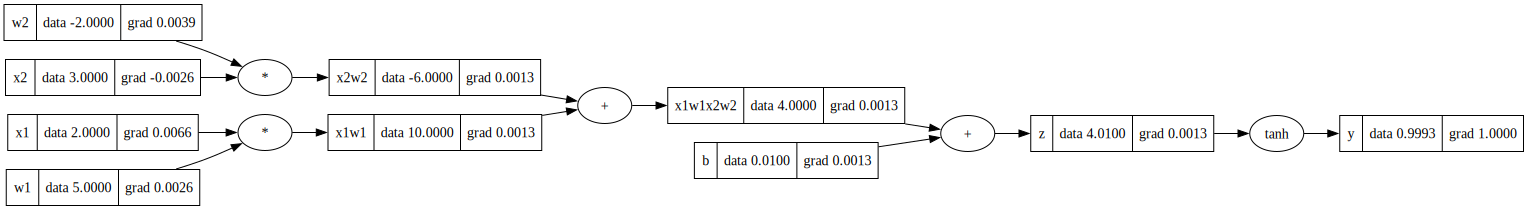

In [14]:
x1w1._backward()
x2w2._backward()

draw_dot(y)

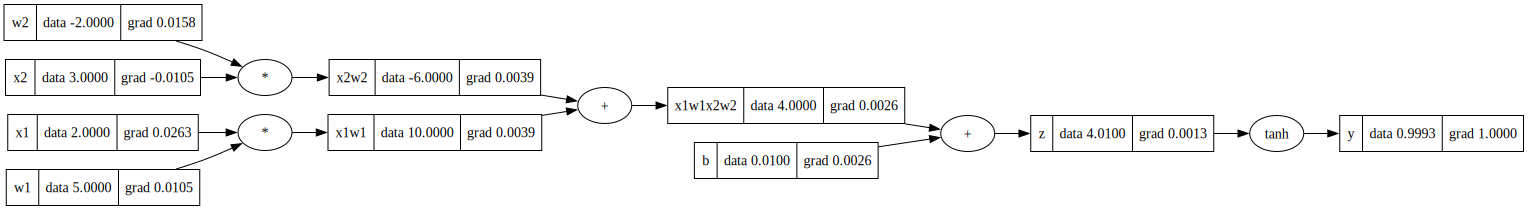

In [15]:
# now to do one iteration of gradient descent 
y.grad = 1.0 

topo = []
visited = set()
def build_topo(node):
    if node not in visited:
        visited.add(node)
        for child in node._prev:
            build_topo(child)
        topo.append(node)

# as the neural network is a directed acyclic graph (DAG), we can use a topological sort to get the order of nodes
# to backpropagate the gradients

build_topo(y)

topo.reverse() 

for node in topo:
    node._backward()

draw_dot(y)

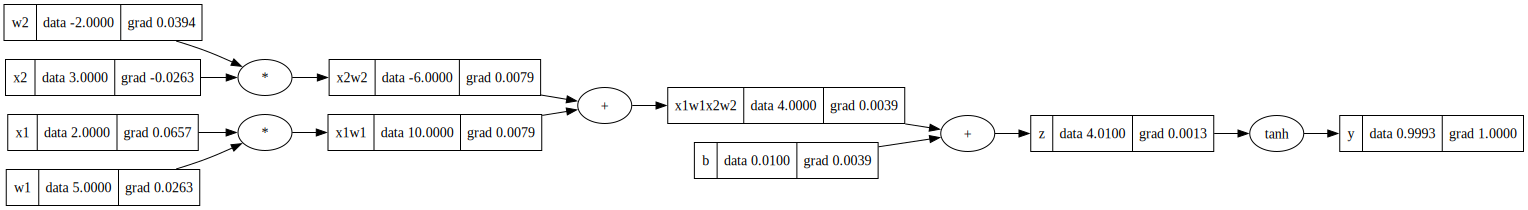

In [16]:
y.backward()

draw_dot(y)

In [17]:
# bug in the current code example

a = Value(2.0, label='a')
b = Value(3.0, label='b')
d = a*b 
e = a + b
d.label = 'd'
e.label = 'e'
f = d*e
f.label = 'f'

# draw_dot(f)
# f.backward()

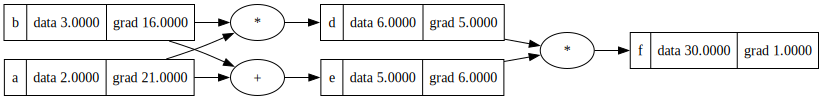

In [18]:
f.backward()
draw_dot(f)

# first gradient of 'd' d.grad is updated into a and b and 
# then gradient of 'e' e.grad is updated into a and b

# which should not be the case.
# the df/db will be get its gradient from both d and e
# df/db = a*df/dd + df/de

### Micro-grad is a scalar valued engine

##### Where the object is created on the number, while pytorch is based on tensors, they are n dimension arrays of scalars.

##### So we create a tensor with single element, a scalar valued tensor.

In [19]:
import torch

# as these are leaf nodes we dont need the grad as inputs are given here.

x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(3.0, requires_grad=True)
w1 = torch.tensor(5.0, requires_grad=True)
w2 = torch.tensor(-2.0, requires_grad=True)
b = torch.tensor(0.01, requires_grad=True)  

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o)
o.backward()  # This will compute the gradients for all tensors with requires_grad=True

print(f"x1.grad: {x1.grad}, x2.grad: {x2.grad}, w1.grad: {w1.grad}, w2.grad: {w2.grad}, b.grad: {b.grad}")



tensor(0.9993, grad_fn=<TanhBackward0>)
x1.grad: 0.006572231184691191, x2.grad: -0.0026288924273103476, w1.grad: 0.0026288924273103476, w2.grad: 0.0039433385245501995, b.grad: 0.0013144462136551738


#### Lets Create a Neural Network

In [33]:
import numpy as np

class Neuron:

    def __init__(self, min):
        self.min = min
        self.w = [Value(np.random.randn(), label=f'w{i}') for i in range(min)]
        self.b = Value(np.random.randn(), label='b')
        
    def __call__(self, x): # obj(input) when we call the object with an input it represents __call__ method
        assert len(x) == self.min, f"Input must have {self.min} elements, got {len(x)}"
        assert all(isinstance(i, Value) for i in x), "Input must be a list of Value objects"
        out = self.b
        for i in range(self.min):
            out += self.w[i] * x[i]
        return out.tanh()  

    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, n_in, n_op):
        self.neurons = [Neuron(n_in) for _ in range(n_op)]
        
    def __call__(self, x):
        assert len(x) == self.neurons[0].min, f"Input must have {self.neurons[0].min} elements, got {len(x)}"
        assert all(isinstance(i, Value) for i in x), "Input must be a list of Value objects"
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [f for neuron in self.neurons for f in neuron.parameters()]

class MLP:

    def __init__(self, n_in, n_op_list):
        ip_op = [n_in] + n_op_list 
        self.layers = [Layer(ip_op[i], ip_op[i+1]) for i in range(len(ip_op)-1)]

    def __call__(self, x):
        assert len(x) == self.layers[0].neurons[0].min, f"Input must have {self.layers[0].neurons[0].min} elements, got {len(x)}"
        assert all(isinstance(i, Value) for i in x), "Input must be a list of Value objects"
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [f for layer in self.layers for f in layer.parameters()] # this will return 2d array of parameters



In [ ]:
x = [Value(1.0, label='x1'), Value(2.0, label='x2'), Value(3.0, label='x3')]
n = Neuron(3)
o = n(x)

print(o)

n = Layer(3, 3)
o = n(x)
print(o)

[Value(data=0.9999200988942806), Value(data=-0.9975270856601455), Value(data=-0.999997548533859)]


In [34]:
n = MLP(3, [4,4,1])
O = n(x)

print(O)

Value(data=0.11207697784817262)


In [38]:
import numpy as np

arr = np.array(n.parameters())
print(arr.shape)


(41,)


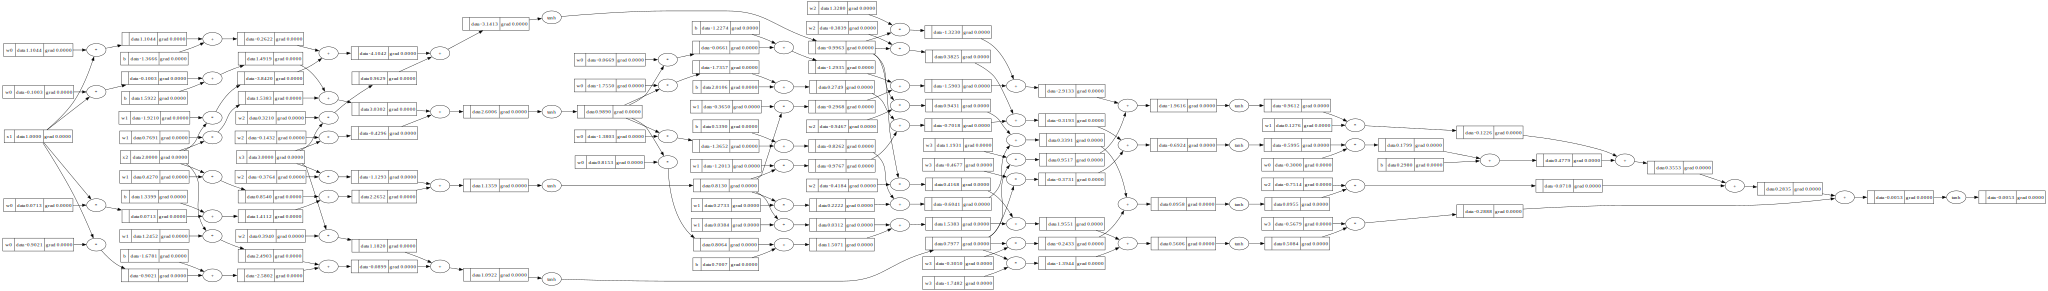

In [23]:
draw_dot(O)

In [ ]:
data_x = [[Value(1.0), Value(2.0), Value(3.0)],
          [Value(2.0), Value(3.0), Value(4.0)],
          [Value(3.0), Value(4.0), Value(5.0)],
          [Value(4.0), Value(5.0), Value(6.0)]]

target = [Value(1.0),Value(-1.0),Value(1.0),Value(-1.0)]


[Value(data=0.11207697784817262), Value(data=0.10347640717144846), Value(data=0.10275584349824084), Value(data=0.10282757437740131)]


it says a slight increase in the w[0] of first layer, it will lead the loss to go down (as it is -ve grad).

In [46]:
# Lets print for the first neural network

print(n.layers[0].neurons[0].w[0])  # This will print the first weight of the first neuron in the first layer
print(n.layers[0].neurons[0].b)  # This will print the bias of the first neuron in the first layer
print(n.layers[0].neurons[0].w[0].grad)  

Value(data=0.5670632950058395)
Value(data=-0.20644511066010873)
0.002053620047946546


In [105]:
for k in range(10000):
    # forward pass
    y_pred = [n(x) for x in data_x]
    loss = sum([(yout-y_pred)**2 for yout, y_pred in zip(target, y_pred)])

    # zero the gradients before the backward pass 
    # as the gradients accumulate
    # this is done to avoid the gradients from previous iterations
    for param in n.parameters():
        param.grad = 0.0

    #backward pass
    loss.backward()

    # update parameters
    for param in n.parameters():
        param.data += -0.02 * param.grad

    # print(f"Iteration {k+1}, Loss: {loss.data:.4f}")

y_pred = [n(x) for x in data_x]
print(y_pred)

[Value(data=0.9902752674384722), Value(data=-0.3330156136710813), Value(data=-0.33353061698659464), Value(data=-0.33353281709298577)]
